[Suitability of Dysphonia Measurements for Telemonitoring of Parkinson's Disease](ieeexplore.ieee.org/document/4636708/) :

> Parkinson’s disease affects over one million people in North America alone. Moreover, an aging population means this number is expected to rise as studies suggest rapidly increasing prevalence rates after the age of 60.

---

> Research has shown that approximately 90% of people with Parkinson exhibit some form of vocal impairment. Vocal impairment may also be one of the earliest indicators for the onset of the illness, and the measurement of voice is noninvasive and simple to administer

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

data_root = '../input/'
df = pd.read_csv(data_root+'parkinsons_updrs.data')
print(df.shape)
print(df.columns)
df.head(2)

(5875, 22)
Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810


In [32]:
male = len(df[df['sex'] == 0])
female = len(df[df['sex'] == 1])
print("There is {0} males and {1} females.".format(male, female))

There is 4008 males and 1867 females.


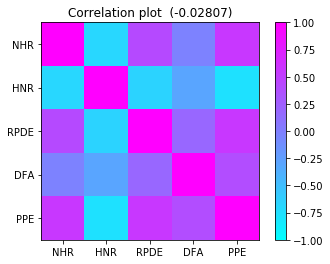

In [33]:
def corr_sub_plot(ax, df, title=""):
    corr = df.corr()
    avg_corr = corr.values[np.triu_indices_from(corr.values,1)].mean()
    ax.set_title(title+" ({0:.4})".format(avg_corr))
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.columns)))
    ax.set_yticklabels(df.columns)
    ax.set_xticklabels(df.columns)
    return ax.imshow(corr, interpolation="nearest", cmap='cool', vmin=-1, vmax=1)

fig, ax = plt.subplots()
cax = corr_sub_plot(ax, df.iloc[:,17:], title="Correlation plot ")
fig.colorbar(cax) 

High negative correlaton between HNR and the other selected variables.

According to [this paper](https://ac.els-cdn.com/S2212017313002788/1-s2.0-S2212017313002788-main.pdf?_tid=0de263ce-372c-4c8f-853b-a19fddab2c8a&acdnat=1522157229_8b968085b447433a596a42663e1b4316): `HNR = 10 * log_10(Energy_in_periodic_part/Energy_in_noise)`

 Voice quality can be dertermined using such a measure [(source)](http://www.fon.hum.uva.nl/praat/manual/Harmonicity.html):

>a healthy speaker can produce a sustained [a] or [i] with a harmonicity of around 20 dB, and an [u] at around 40 dB; the difference comes from the high frequencies in [a] and [i], versus low frequencies in [u], resulting in a much higher sensitivity of HNR to jitter in [a] and [i] than in [u]. Hoarse speakers will have an [a] with a harmonicity much lower than 20 dB. We know of a pathological case where a speaker had an HNR of 40 dB for [i], because his voice let down above 2000 Hz. 

Since usually men and women have statistically different fundamental frequencies for their voices we can probably find something, by those correlation come from with a different color for sex.

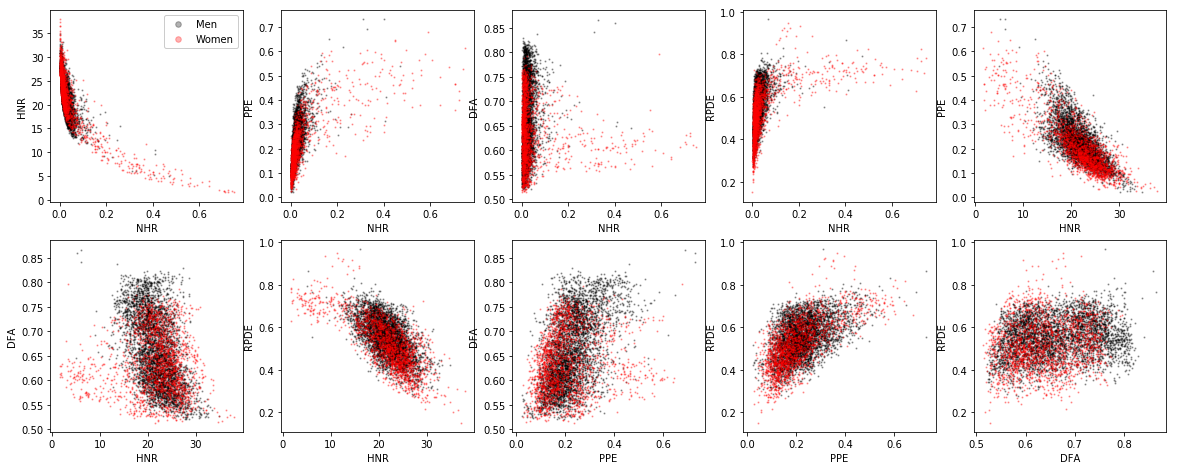

In [34]:
from itertools import combinations
def scatter_patient(df, subject_list, columns, patient_filter):
    fig, ax = plt.subplots(figsize=(20,12))
    f = [comb for comb in combinations(range(len(columns)), 2)]
    
    for _, fp, _ in patient_filter:
        fp = fp & subject_list
        
    men = subject_list & (df['sex'] == 0)
    women = subject_list & (df['sex'] == 1)
    for i in range(len(f)):
        plt.subplot(3,5,i + 1)
        column_1 = columns[f[i][0]]
        column_2 = columns[f[i][1]]
        
        for name, fp, color in patient_filter:
            plt.scatter(df[fp][column_1], df[fp][column_2], alpha=0.3, marker='.', color=color, s=5, label=name)
        
        plt.xlabel(column_1)
        plt.ylabel(column_2)
        if(i == 0 or i == len(f)):
            plt.legend(markerscale=5, framealpha=1)

sex_filter_patient = [('Men', df['sex'] == 0, 'black'), 
                      ('Women', df['sex'] == 1, 'red')]
scatter_patient(df, df['subject#'] == df['subject#'], ['NHR', 'HNR', 'PPE', 'DFA', 'RPDE'], sex_filter_patient)

In the end apparently not much difference. Women, even if represented twice less than men, tends to have more spreaded graphs. 

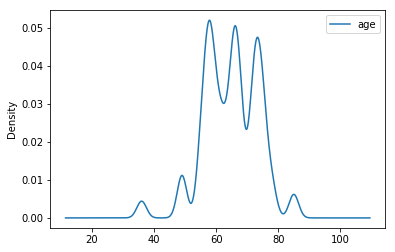

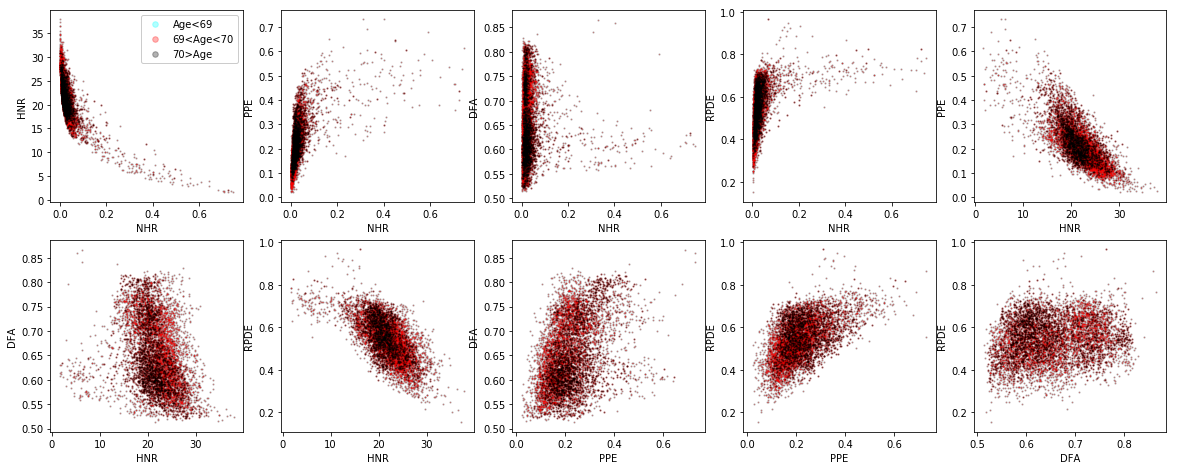

In [35]:
pd.DataFrame(df.age).plot(kind="density")
low_margin = 69
upper_margin = 70

less = df['age'] <= low_margin
between = ((less == 0) & df['age'] <= upper_margin )
more = df['age'] > upper_margin

age_filter_patient = [('Age<{}'.format(low_margin), less, 'cyan'), 
                      ('{0}<Age<{1}'.format(low_margin, upper_margin), between, 'red'),
                      ('{}>Age'.format(upper_margin), more, 'black')]
scatter_patient(df, df['subject#'] == df['subject#'], ['NHR', 'HNR', 'PPE', 'DFA', 'RPDE'], age_filter_patient)

In [36]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.keys]

numerical = ['Jitter(%)', 'Jitter(Abs)','Jitter:RAP','Jitter:PPQ5','Jitter:DDP',
            'Shimmer','Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','Shimmer:APQ11','Shimmer:DDA',
            'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'age', 'sex']

features_pipe = make_pipeline(FeatureSelector(numerical),
                              StandardScaler())
targets_pipe = make_pipeline(StandardScaler())

X = features_pipe.fit_transform(df)

targets = df[['motor_UPDRS', 'total_UPDRS']]
y = targets_pipe.fit_transform(targets)

input_width = X.shape[1]

In [37]:
from sklearn.model_selection import train_test_split
# Not quite sure at the moment if a stratified splitting is needed here
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=4422)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [38]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation

nf = MultiOutputRegressor(RandomForestRegressor(max_depth=30, n_estimators=50, random_state=0), n_jobs=-1)
nf.fit(X, y)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
           n_jobs=-1)

In [39]:
nf.score(X_test, y_test), cross_validation.cross_val_score(nf, X_test, y_test, scoring='mean_squared_error').mean()

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


(0.9877097645489307, -0.24563735540066808)

In [61]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=150, verbose=1, mode='min')

# forked from: gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def __init__(self, skip=5, refresh_rate=5, figsize=(17,10), zoom_delta=7):
        self.skip = skip
        self.refresh_rate=5
        self.figsize=figsize
        self.fig = plt.figure()
        self.zoom_delta = zoom_delta
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        last_loss = logs.get('loss')
        last_val_loss = logs.get('val_loss')

        self.x.append(self.i)
        self.losses.append(last_loss)
        self.val_losses.append(last_val_loss)
        self.i += 1
        
        if((self.i % self.refresh_rate == 0 and self.i > self.skip) or self.i == self.skip):
            clear_output(wait=True)
            fig = plt.figure(figsize=self.figsize)
            ax = fig.add_subplot(2, 1, 1)
            ax.plot(self.x[self.skip:], self.losses[self.skip:], label="loss")
            ax.plot(self.x[self.skip:], self.val_losses[self.skip:], label="val_loss")
            plt.title("{0:.4} loss & {1:.4} validation loss (epoch={2})".format(last_loss, last_val_loss, self.i))
            plt.legend()
            
            if(self.i > 100):
                axins = zoomed_inset_axes(ax, 3, loc=7)
                axins.plot(self.x[self.skip:], self.losses[self.skip:])
                axins.plot(self.x[self.skip:], self.val_losses[self.skip:])
                last_epochs = slice(self.i-self.zoom_delta-1,self.i-1)
                axins.set_xlim(self.i-self.zoom_delta-1, self.i-1)
                min_y = min(min(self.losses[last_epochs]), min(self.val_losses[last_epochs]))
                max_y =  max(max(self.losses[last_epochs]), max(self.val_losses[last_epochs]))
                axins.set_ylim(min_y, max_y)
                mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")

            plt.show()
        
plot_losses = PlotLosses()
model = Sequential([
    Dense(110, input_shape=(input_width,), kernel_initializer='he_uniform', activation='relu'),
    Dropout(0.3),
    Dense(200, kernel_initializer='he_uniform', activation='relu'),
    Dropout(0.4),
    Dense(200, kernel_initializer='he_uniform', activation='relu'),
    Dropout(0.4),
    Dense(100, kernel_initializer='he_uniform', activation='relu'),
    Dense(10, kernel_initializer='he_uniform', activation='relu'),
    Dense(2, kernel_initializer='he_uniform', activation='linear'),
])

model.compile(optimizer='adam', loss='mean_squared_error')

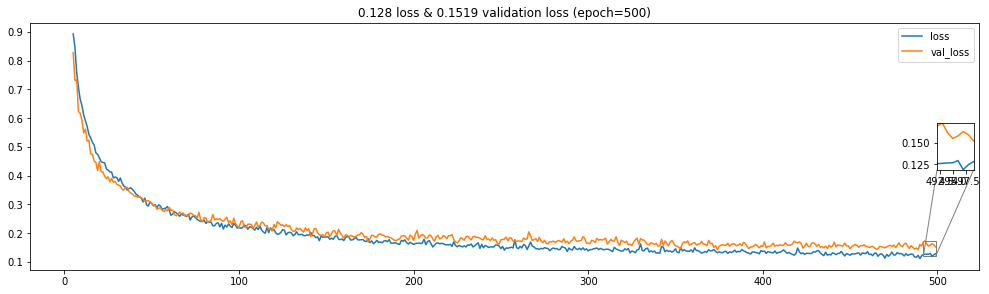

Epoch 00504: early stopping


In [62]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=20, verbose=0, validation_data=(X_test, y_test), callbacks=[earlystop, plot_losses])

In [63]:
model.save('my_model.h5')

In [ ]:
model.predict()